In [1]:

import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow
from keras.datasets import mnist

In [2]:
def load_az_dataset(datasetPath):
    # initialize the list of data and labels
    data = []
    labels = []
    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(datasetPath):
        # parse the label and image from the row
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and repshape them into a 28x28 matrix
        image = image.reshape((28, 28))
        # update the list of data and labels
        data.append(image)
        labels.append(label)
        # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    # return a 2-tuple of the A-Z data and labels
    return (data, labels)

In [3]:
def load_mnist_dataset():
    # load the MNIST dataset and stack the training data and testing
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])
    # return a 2-tuple of the MNIST data and labels
    return (data, labels)

## Load the A-Z and MNIST datasets

In [4]:
print("[INFO] loading datasets...")
(azData, azLabels) =load_az_dataset('A_Z Handwritten Data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...


In [6]:
print(azData.shape)
print(azLabels.shape)
print(digitsData.shape)
print(digitsLabels.shape)

(372451, 28, 28)
(372451,)
(70000, 28, 28)
(70000,)


## Preparing the data and the labels

In [7]:

azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}


# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]



In [8]:
print(data.shape)
print(labels.shape)

(442451, 32, 32, 1)
(442451, 36)


## Split the data into train and test 

In [9]:

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.20, stratify=labels, random_state=42)

In [10]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)


(353960, 32, 32, 1)
(88491, 32, 32, 1)
(353960, 36)
(88491, 36)


## Data augmentation

In [11]:

# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")


## Build and train the model 

In [18]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data

        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
            kernel_regularizer=l2(reg))(act1)

        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
            padding="same", use_bias=False,
            kernel_regularizer=l2(reg))(act2)

        # the third block of the ResNet module is another set of 1x1
        # CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False,
            kernel_regularizer=l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to
        # the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride,
                use_bias=False, kernel_regularizer=l2(reg))(act1)

        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x
    @staticmethod
    def build(width, height, depth, classes, stages, filters,
        reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # set the input and then apply a BN followed by CONV
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(inputs)
        x = Conv2D(filters[0], (3, 3), use_bias=False,
            padding="same", kernel_regularizer=l2(reg))(x)

        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model

In [19]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size


EPOCHS = 10
INIT_LR = 1e-1
BS = 128

# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3), (64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [ ]:

# train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
        epochs=EPOCHS,
    class_weight=classWeight,
    verbose=1)


[INFO] training network...
Epoch 1/10
2765/2765 [==============================] - 5067s 2s/step - loss: 2.1921 - accuracy: 0.8570 - val_loss: 0.5148 - val_accuracy: 0.9072
Epoch 2/10
 878/2765 [========>.....................] - ETA: 1:06:59 - loss: 1.1684 - accuracy: 0.9129

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.17      0.82      0.28      1381
           1       0.97      0.96      0.96      1575
           2       0.84      0.92      0.88      1398
           3       0.92      0.97      0.95      1428
           4       0.81      0.90      0.85      1365
           5       0.45      0.88      0.60      1263
           6       0.88      0.96      0.92      1375
           7       0.90      0.97      0.93      1459
           8       0.85      0.96      0.90      1365
           9       0.90      0.97      0.93      1392
           A       0.96      0.96      0.96      2774
           B       0.94      0.95      0.94      1734
           C       0.98      0.95      0.97      4682
           D       0.91      0.90      0.91      2027
           E       0.98      0.96      0.97      2288
           F       0.93      0.99      0.96       232
           G       0.91      0.92      0.91      115

C:\Users\Yasmine\anaconda3\envs\ten\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


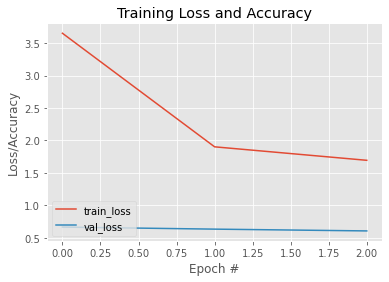

In [14]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=labelNames))

#save the model to disk
print("[INFO] serializing network...")
model.save("handwriting.model", save_format="h5")

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")
